template: [ENEURO PAPER](https://www.eneuro.org/content/eneuro/12/11/ENEURO.0270-25.2025.full.pdf)

In [41]:
import mne
from mne.preprocessing.eyetracking import read_eyelink_calibration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from pathlib import Path
from sklearn.linear_model import HuberRegressor

# 1. Functions

## 1.1 Load ASC


In [42]:
def load_events_from_asc(file_path: str, window_ms: float = 150.0):
    """
    Load EyeLink .asc file and return (fixations_df, saccades_df, blinks_df, raw_et).

    - Adds `event_type` to each table.
    - Marks saccades near blinks within ±window_ms via `near_blink` and `blink_dist_ms`.
    - Computes saccade amplitude in degrees (visual angle) safely.
    """
    # 1) Load raw EyeLink data
    raw_et = mne.io.read_raw_eyelink(file_path, find_overlaps=False, overlap_threshold=0.1, verbose="ERROR") # tBD: comapre to overlap = true

    # 2) Read calibration
    cals = read_eyelink_calibration(
        file_path, screen_distance=0.729, screen_size=(0.552, 0.307), screen_resolution=(1920, 1080)
    )[0]
    # 3) convert units to radians of visual angle
    print("Convert units to radians of visual angle...")
    raw_et = mne.preprocessing.eyetracking.convert_units(raw_et, calibration=cals, to="radians")
    print("Done!")

    # 4) Interpolate blinks
    raw_et = mne.preprocessing.eyetracking.interpolate_blinks(raw_et, buffer=(0.05, 0.2), interpolate_gaze=False)

    # 5) DataFrames
    et_dfs = raw_et._raw_extras[0]["dfs"]

    fixations_df = et_dfs["fixations"].copy()
    fixations_df["event_type"] = "fixation"

    blinks_df = et_dfs["blinks"].copy()
    blinks_df["event_type"] = "blink"

    saccades_df = et_dfs["saccades"].copy()
    saccades_df["event_type"] = "saccade"

    # 6) Mark saccades near blinks
    saccades_df = annotate_saccades_near_blinks_in_df(saccades_df, blinks_df, window_ms=window_ms)

    # 7) Compute saccade amplitude (deg) from start/end in visual-angle coords
    saccades_df["amplitude_deg"] = saccades_df.apply(
        lambda r: compute_saccade_amplitude_from_radians(r.sacc_start_x, r.sacc_start_y,
                                                         r.sacc_end_x, r.sacc_end_y),
        axis=1
    )

    return fixations_df, saccades_df, blinks_df, raw_et

## 1.1 Annotate Blinks

In [43]:
"""
def annotate_saccades_near_blinks_in_df(saccades_df: pd.DataFrame,
                                        blinks_df: pd.DataFrame,
                                        window_ms: float) -> pd.DataFrame:
    blinks = blinks_df.copy()
    saccades = saccades_df.copy()
    w = window_ms / 1000.0  # s

    # 1. get blinks
    B = blinks[["time", "end_time"]].to_numpy(float)

    # 2. expand blink times by ±w
    B[:, 0] -= w
    B[:, 1] += w
    B = B[np.argsort(B[:, 0])]  # sort by start

    # 3. get saccades
    S = saccades[["time", "end_time"]].to_numpy(float)

    near_blinks = []
    for sac_start, sac_end in S:
      near_blink = False
      for blink_start, blink_end in B:
        # if the end of the blink is within the saccade
        if sac_start < blink_end and sac_end > blink_end:
          near_blink = True
          break
        # if the beginning of the blink is within the saccade
        elif sac_start < blink_start and sac_end > blink_start:
          near_blink = True
          break
      near_blinks.append(near_blink)

    saccades['near_blink'] = near_blinks
    return saccades
  """

'\ndef annotate_saccades_near_blinks_in_df(saccades_df: pd.DataFrame,\n                                        blinks_df: pd.DataFrame,\n                                        window_ms: float) -> pd.DataFrame:\n    blinks = blinks_df.copy()\n    saccades = saccades_df.copy()\n    w = window_ms / 1000.0  # s\n\n    # 1. get blinks\n    B = blinks[["time", "end_time"]].to_numpy(float)\n\n    # 2. expand blink times by ±w\n    B[:, 0] -= w\n    B[:, 1] += w\n    B = B[np.argsort(B[:, 0])]  # sort by start\n\n    # 3. get saccades\n    S = saccades[["time", "end_time"]].to_numpy(float)\n\n    near_blinks = []\n    for sac_start, sac_end in S:\n      near_blink = False\n      for blink_start, blink_end in B:\n        # if the end of the blink is within the saccade\n        if sac_start < blink_end and sac_end > blink_end:\n          near_blink = True\n          break\n        # if the beginning of the blink is within the saccade\n        elif sac_start < blink_start and sac_end > blink_st

In [44]:
def annotate_saccades_near_blinks_in_df(
    saccades_df: pd.DataFrame,
    blinks_df: pd.DataFrame,
    window_ms: float
) -> pd.DataFrame:
    """
    Flag saccades as near a blink if the blink START or END falls within
    the saccade interval expanded by ±window_ms.

    Adds:
      - near_blink (bool)
    """
    saccades = saccades_df.copy()
    w = window_ms / 1000.0  # seconds

    # get blinks
    b = blinks_df[["time", "end_time"]].to_numpy(float)
    # sort by blink start
    b = b[np.argsort(b[:, 0])]

    S = saccades[["time", "end_time"]].to_numpy(float)

    near_blinks = []
    for sac_start, sac_end in S:
        win_start = sac_start - w
        win_end   = sac_end + w

        near = False
        for blink_start, blink_end in b:
            # since sorted by blink_start, if blink_start is already after window, stop
            if blink_start > win_end:
                break

            # flag if blink start OR blink end is inside the expanded saccade window
            if (win_start <= blink_start <= win_end) or (win_start <= blink_end <= win_end):
                near = True
                break

        near_blinks.append(near)

    saccades["near_blink"] = near_blinks
    return saccades


## 1.2 Compute Saccade Amplitude


In [45]:
def compute_angle(x1, y1, z1, x2, y2, z2):

    p1 = np.array([x1, y1, z1]) # cartesian coordinates of point 1
    p2 = np.array([x2, y2, z2]) # cartesian coordinates of point 2

    # compute the angle between p1 and p2 (in radians)
    denom = (np.linalg.norm(p1) * np.linalg.norm(p2))
    if denom == 0:
        return np.nan
    alpha_rad= np.arccos(np.clip(np.dot(p1,p2)/denom,-1.,1.))

    # convert the angle from radians to degrees
    return math.degrees(alpha_rad)

def compute_saccade_amplitude(sx, sy, ex, ey):
    # convert all to cartesian
    t1 = np.radians(sx) + np.pi/2
    p1 = np.radians(sy) + np.pi/2

    t2 = np.radians(ex) + np.pi/2
    p2 = np.radians(ey) + np.pi/2

    x1 = np.cos(p1) * np.sin(t1)
    y1 = np.sin(p1) * np.sin(t1)
    z1 = np.cos(t1)

    x2 = np.cos(p2) * np.sin(t2)
    y2 = np.sin(p2) * np.sin(t2)
    z2 = np.cos(t2)

    return compute_angle(x1, y1, z1, x2, y2, z2)

def compute_saccade_amplitude_from_radians(sx, sy, ex, ey):
    """
    Compute saccade amplitude (deg) from start/end in visual-angle radians.
    """
    # Cartesian coordinates on unit sphere
    x1 = np.cos(sy) * np.sin(sx)
    y1 = np.sin(sy) * np.sin(sx)
    z1 = np.cos(sx)

    x2 = np.cos(ey) * np.sin(ex)
    y2 = np.sin(ey) * np.sin(ex)
    z2 = np.cos(ex)

    # Angle via dot product
    dot = np.clip(x1*x2 + y1*y2 + z1*z2, -1.0, 1.0)
    alpha_rad = np.arccos(dot)
    return np.degrees(alpha_rad)


## 1.3 Plot Main Sequence

In [88]:
def plot_main_sequence(df: pd.DataFrame,
                       out_path: str = None,
                       out_file_format: str = "svg",
                       by_eye: str="both",
                       title: str="Main Sequence",
                       x_label: str="Saccade amplitude (deg)",
                       y_label: str="Peak velocity (deg/s)",
                       drop_near_blinks: bool=True,
                       ):

  if by_eye not in {"all", "left", "right", "both"}:
        raise ValueError("by_eye must be one of: 'all', 'left', 'right', 'both'")

  # keep only valid saccades
  s = df.query("event_type == 'saccade'").copy()
  s = s.dropna(subset=["sacc_visual_angle","peak_velocity","eye"])
  s = s[(s["amplitude_deg"] > 0) & (s["peak_velocity"] > 0)]

  if drop_near_blinks:
    s = s.query("near_blink == False").copy()

  # plausibility
  s = s[(s["sacc_visual_angle"] > 0.1) & (s["sacc_visual_angle"] <= 30)]
  s = s[(s["peak_velocity"] > 30) & (s["peak_velocity"] <= 1000)]

  fig, ax = plt.subplots()
  if by_eye == "all":
    for eye, sub in s.groupby("eye"):
      ax.scatter(sub["sacc_visual_angle"], sub["peak_velocity"], s=10, label=str(eye))
      ax.legend(title="Eye")
  elif by_eye in {"left", "right", "both"}:
    eye_mapping = {"left": "L", "right": "R", "both": "both"}
    chosen_eye = eye_mapping[by_eye]
    s = s.query(f"eye == @chosen_eye").copy()
    ax.scatter(s["sacc_visual_angle"], s["peak_velocity"], s=10)
  else:
    ax.scatter(s["sacc_visual_angle"], s["peak_velocity"], s=10)

  title_map = {
        "all": "All eyes",
        "left": "Left eye only",
        "right": "Right eye only",
        "both": "Binocular only",
    }

  ax.set_xscale("log"); ax.set_yscale("log")
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  ax.set_title(f"{title} — {title_map[by_eye]}" + (" (blink-cleaned)" if drop_near_blinks else ""))

  fig = ax.figure
  fig.tight_layout()
  plt.show()
  fig.savefig(f"{out_path}/{title.lower().replace(' ', '_')}-{by_eye}Eyes-{'_blinkCleaned' if drop_near_blinks else ''}.{out_file_format}", bbox_inches="tight")
  print(f"Plot saved to file '{out_path}/{title.lower().replace(' ', '_')}-{by_eye}Eyes{'_blinkCleaned' if drop_near_blinks else ''}.{out_file_format}'")

### 1.3.1. Try Out: Drop the outliers 
by treating them as residuals of the main sequence 

In [47]:
def detect_main_sequence_outliers(
    saccades_df: pd.DataFrame,
    mad_thresh: float = 3.0,
) -> pd.DataFrame:
    """
    Robust main-sequence outlier detection in log-log space.
    Adds: ms_pred_log10v, ms_resid, ms_is_outlier
    """
    x = np.log10(saccades_df["sacc_visual_angle"].to_numpy())
    y = np.log10(saccades_df["peak_velocity"].to_numpy())

    model = HuberRegressor().fit(x.reshape(-1, 1), y)
    yhat = model.predict(x.reshape(-1, 1))
    resid = y - yhat

    med = np.median(resid)
    mad = np.median(np.abs(resid - med))
    is_outlier = np.abs(resid - med) > (mad_thresh * mad)

    out = saccades_df.copy()
    out["ms_pred_log10v"] = yhat
    out["ms_resid"] = resid
    out["ms_is_outlier"] = is_outlier
    return out

In [48]:
def log_main_sequence_outliers(
    s_with_flags: pd.DataFrame,
    out_path: str,
    base_name: str,
) -> dict:
    """
    Writes CSV of outliers + JSON summary. Returns summary dict.
    """
    os.makedirs(out_path, exist_ok=True)

    outliers = s_with_flags[s_with_flags["ms_is_outlier"]]
    out_file = os.path.join(out_path, f"{base_name}_outliers.csv")
    outliers.to_csv(out_file, index=False)

    summary = {
        "n_total": int(len(s_with_flags)),
        "n_outliers": int(len(outliers)),
        "outlier_rate": float(len(outliers) / len(s_with_flags)),
        "saved_to": out_file,
    }

    print("\nMain sequence outlier summary")
    print("-" * 30)
    print(f"{'Total saccades':<18}: {summary['n_total']:>6}")
    print(f"{'Outliers':<18}: {summary['n_outliers']:>6}")
    print(f"{'Outlier rate':<18}: {summary['outlier_rate'] * 100:>5.2f}%")
    print(f"{'Saved to':<18}: {summary['saved_to']}")

In [49]:

def plot_main_sequence(
    saccades_df: pd.DataFrame,
    out_path: str,
    out_file_format: str,
    by_eye: str,
    title: str,
    x_label: str,
    y_label: str,
    drop_near_blinks: bool,

    drop_ms_outliers: bool = False,
    ms_outlier_mad_thresh: float = 4.3,
):
    """
    Plots main sequence (log-log). Optionally drops main-sequence outliers and logs them.
    Assumes saccades_df already contains only valid saccades and has stable columns.
    """

    s = saccades_df.copy()

    if drop_near_blinks:
        s = s[s["near_blink"] == False]

    if by_eye != "all":
        eye_map = {"left": "L", "right": "R", "both": "both"}
        s = s[s["eye"] == eye_map[by_eye]]

    base_name = f"{title.lower().replace(' ', '_')}-{by_eye}Eyes" + ("_blinkCleaned" if drop_near_blinks else "")

    if drop_ms_outliers:
        s_flagged = detect_main_sequence_outliers(s, mad_thresh=ms_outlier_mad_thresh)

        log_main_sequence_outliers(s_flagged, out_path=out_path, base_name=base_name)

        s = s_flagged[~s_flagged["ms_is_outlier"]]

    fig, ax = plt.subplots()

    if by_eye == "all":
        for eye, sub in s.groupby("eye"):
            ax.scatter(sub["sacc_visual_angle"], sub["peak_velocity"], s=10, label=str(eye))
        ax.legend(title="Eye")
    else:
        ax.scatter(s["sacc_visual_angle"], s["peak_velocity"], s=10)

    ax.set_xscale("log"); ax.set_yscale("log")
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f"{title} — {by_eye}" + (" (blink-cleaned)" if drop_near_blinks else ""))
    plt.show()

    title_map = {
            "all": "All eyes",
            "left": "Left eye only",
            "right": "Right eye only",
            "both": "Binocular only",
        }

    suffix = []
    if drop_near_blinks:
        suffix.append("blink-cleaned")
    if drop_ms_outliers:
        suffix.append(f"outliers-dropped (>{ms_outlier_mad_thresh} MAD)")
    ax.set_title(f"{title} — {title_map[by_eye]}" + (f" ({', '.join(suffix)})" if suffix else ""))

    fig.tight_layout()
    plt.show()

    if out_path is not None:
        os.makedirs(out_path, exist_ok=True)
        fname = base_name + ("_msOutliersDropped" if drop_ms_outliers else "")
        fig.savefig(os.path.join(out_path, f"{fname}.{out_file_format}"), bbox_inches="tight")

## 1.4 Plot Fixation Duration

In [50]:
def plot_fixation_duration(et_combined_df: pd.DataFrame,
                           out_path: str,
                           out_file_format: str,
                           by_eye: str,          # "all", "left", "right", "both"
                           min_ms: float=60,           # drop ultra-short blinks/micro-fixations
                           max_ms: float=1000,         # drop implausibly long fixations
                           bin_w: int=20,              # bin width in ms
                           title: str="Fixation Durations",
                           x_label: str="Fixation duration (ms)",
                           y_label: str="Count"
                           ):

    if by_eye not in {"all", "left", "right", "both"}:
        raise ValueError("by_eye must be one of: 'all', 'left', 'right', 'both'")

    # 1) Fixations only, convert seconds → ms
    fix = et_combined_df.loc[et_combined_df["event_type"] == "fixation", ["duration", "eye"]].copy()
    fix = fix.dropna(subset=["duration"])
    fix["duration_ms"] = fix["duration"] * 1000.0

    # 2) Filter by eye
    if by_eye != "all":
      eye_mapping = {"left": "L", "right": "R", "both": "both"}
      chosen_eye = eye_mapping[by_eye]
      fix = fix.query(f"eye == @chosen_eye").copy()

    # 3) Filter by plausible duration range
    dur = fix["duration_ms"]
    dur = dur[(dur >= min_ms) & (dur <= max_ms)]
    if dur.empty:
        raise ValueError("No fixation durations after filtering. Check inputs or ranges.")

    fig, ax = plt.subplots()
    ax.hist(dur)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    title_map = {
        "all": "All eyes",
        "left": "Left eye only",
        "right": "Right eye only",
        "both": "Binocular only",
    }
    ax.set_title(f"{title} — {title_map[by_eye]}")
    plt.show()

    fig = ax.figure
    fig.tight_layout()
    fig.savefig(f"{out_path}/{title.lower().replace(' ', '_')}-{by_eye}Eyes.{out_file_format}", bbox_inches="tight")
    print(f"Plot saved to file '{out_path}/{title.lower().replace(' ', '_')}-{by_eye}Eyes.{out_file_format}'")

## 1.5 Plot Fixation Frequency

I don't understand plot B

## 1.6 Saccade amplitude
Plot C

In [51]:
def saccade_amplitude(
        saccades_df,
        by_eye,
        title,
        x_label,
        y_label,
        out_path,
        out_file_format
):
    # 1) Filter by eye
    if by_eye != "all":
        eye_mapping = {"left": "L", "right": "R", "both": "both"}
        chosen_eye = eye_mapping[by_eye]
        df = saccades_df.query("eye == @chosen_eye").copy()
    else:
        df = saccades_df.copy()

    # 2) Select saccade amplitudes in degrees
    # amplitudes = df["amplitude_deg"].dropna()
    all_amplitudes = df["sacc_visual_angle"].dropna()
    amplitudes = all_amplitudes[all_amplitudes <= 40]

    # Identify dropped outliers
    dropout = len(all_amplitudes[all_amplitudes > 40])

    # Report counts
    print(f"Total saccades: {len(all_amplitudes)}")
    print(f"Kept saccades (<=40°): {len(amplitudes)}")
    print(f"Dropped outliers (>40°): {dropout}, {(dropout/len(all_amplitudes))*100:.2f}%")

    # 3) Create figure
    fig, ax = plt.subplots(figsize=(5, 4))

    ax.hist(
        amplitudes,
        bins=40,
        edgecolor="black"
    )

    # 4) Labels & title
    title_map = {
        "all": "All eyes",
        "left": "Left eye only",
        "right": "Right eye only",
        "both": "Binocular only",
    }

    ax.set_title(f"{title} — {title_map[by_eye]}")
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xlim(left=0)

    fig.tight_layout()

    # 5) Save & show
    out_file = f"{out_path}/{title.lower().replace(' ', '_')}-{by_eye}Eyes.{out_file_format}"
    fig.savefig(out_file, bbox_inches="tight")
    print(f"Plot saved to file '{out_file}'")
    plt.show()
    plt.close(fig)


## 1.7 Saccade Duration
Plot D

In [52]:
def saccade_duration(
        saccades_df,
        by_eye,
        title,
        x_label,
        y_label,
        out_path,
        out_file_format,
        max_saccade_duration: int = 120
        ):

    # 1) Filter by eye
    if by_eye != "all":
        eye_mapping = {"left": "L", "right": "R", "both": "both"}
        chosen_eye = eye_mapping[by_eye]
        df = saccades_df.query("eye == @chosen_eye").copy()
    else:
        df = saccades_df.copy()

    # 2) Convert duration from seconds to milliseconds
    durations = (df["duration"] * 1000).dropna()

    # 3) Drop saccades >120ms
    if max_saccade_duration is not None:
        durations = durations[durations <= max_saccade_duration]
        durations_copy = durations.copy()
        dropout = len(durations_copy[durations > max_saccade_duration])
        print(f"Dropped {(dropout/len(durations))*100:.2f}% samples of duration > {max_saccade_duration} milliseconds.")

    # 4) Create figure
    fig, ax = plt.subplots(figsize=(5, 4))

    ax.hist(
        durations,
        bins=40,
        edgecolor="black"
    )

    # 5) Labels & title
    title_map = {
        "all": "All eyes",
        "left": "Left eye only",
        "right": "Right eye only",
        "both": "Binocular only",
    }

    ax.set_title(f"{title} — {title_map[by_eye]}")
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xlim(left=0)

    fig.tight_layout()

    # 6) Save before show
    out_file = f"{out_path}/{title.lower().replace(' ', '_')}-{by_eye}Eyes.{out_file_format}"
    fig.savefig(out_file, bbox_inches="tight")
    print(f"Plot saved to file '{out_file}'")

    plt.show()
    plt.close(fig)

## 1.8 Fixation Frequency
PLOT B

In [53]:
def fixation_frequency(fixations_df,
                       by_eye,
                       title,
                       x_label,
                       y_label,
                       out_path,
                       out_file_format
                       ):
    # 1) Filter by eye
    if by_eye != "all":
        eye_mapping = {"left": "L", "right": "R", "both": "both"}
        chosen_eye = eye_mapping[by_eye]
        fixations_df = fixations_df.query("eye == @chosen_eye").copy()
    else:
        fixations_df = fixations_df.copy()

    # 1) calculate in which second the fixation happened
    fixations_df["sec"] = fixations_df["time"].astype(float).floordiv(1).astype(int)

    # 2) Count fixations per second
    fix_per_sec = fixations_df.groupby("sec").size()  # pd.Series w/ index = second, value = count

    # 3) Create figure
    plt.figure()
    plt.hist(
        fix_per_sec.values,
        bins=np.arange(fix_per_sec.max() + 2) - 0.3,
        width=0.6,
    )

    plt.xlim(left=-0.3)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # 6) Save before show
    out_file = f"{out_path}/{title.lower().replace(' ', '_')}-{by_eye}Eyes.{out_file_format}"
    plt.savefig(out_file, bbox_inches="tight")
    print(f"Plot saved to file '{out_file}'")

    plt.show()

## 1.9 Saccade angular histogram
PLOT F

In [54]:
def saccade_angular_histogram(saccades_df,
                              by_eye,
                              title,
                              cart_title,
                              out_path,
                              out_file_format,
                              refinement = False
                              ):

    # 1) Filter by eye
    if by_eye != "all":
        eye_mapping = {"left": "L", "right": "R", "both": "both"}
        chosen_eye = eye_mapping[by_eye]
        saccades_df = saccades_df.query("eye == @chosen_eye").copy()
    else:
        saccades_df = saccades_df.copy()

    # 2) Compute saccade angles
    dx = saccades_df["sacc_end_x"] - saccades_df["sacc_start_x"]
    dy = saccades_df["sacc_end_y"] - saccades_df["sacc_start_y"]

    # Angle in radians, then degrees
    angles_rad = np.arctan2(dy, dx)
    angles_deg = np.degrees(angles_rad)

    # Optional: map to [0, 360)
    angles_deg = (angles_deg + 360) % 360

    # Convert degrees back to radians for polar plotting
    angles_rad = np.deg2rad(angles_deg)

    # 4) Refinemements (optional) -> don't seem to make a big difference
    if refinement:
        # Exclude microsaccades/artefacts
        mask = (saccades_df["amplitude_deg"] >= 1.0)
        angles_rad = angles_rad[mask]

        # Weight Saccade Amplitude
        weights = saccades_df.loc[mask, "amplitude_deg"]
        angles_rad = angles_rad[mask]
        angles_deg = angles_deg[mask]

        # 5) create Figure
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111, polar=True)

        ax.hist(
            angles_rad,
            bins=36,        # 10° bins
            weights=weights,
            edgecolor="black"
        )
    else:
        # 5) create Figure
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111, polar=True)

        ax.hist(
            angles_rad,
            bins=36,        # 10° bins
            edgecolor="black"
        )

    # Configure axes
    ax.set_theta_zero_location("E")   # 0° to the right
    ax.set_theta_direction(1)         # counter-clockwise
    ax.set_title(title)
    plt.tight_layout()

    # 5) Save before show
    out_file = f"{out_path}/{title.lower().replace(' ', '_')}-{by_eye}Eyes.{out_file_format}"
    plt.savefig(out_file, bbox_inches="tight")
    print(f"Plot saved to file '{out_file}'")

    plt.show()

    # 6) Create Figure 2: Cartesian Angular Histogramm
    plt.hist(angles_deg, bins=np.arange(0, 361, 10), edgecolor="black")
    plt.xlabel("Saccade direction (deg)")
    plt.ylabel("Count")
    plt.title(cart_title)

    # 7) Save before show
    out_file = f"{out_path}/{cart_title.lower().replace(' ', '_')}-{by_eye}Eyes.{out_file_format}"
    plt.savefig(out_file, bbox_inches="tight")
    print(f"Plot saved to file '{out_file}'")

    plt.show()


# 2. Main

## 2.1 Load the .asc-file into a dataframe


### Specify directories and filenames

In [55]:
asc_filepath = "data"   # from where to load the .asc files
csv_filepath = Path("data/out")    # from where to load the .csv files, if asc was already loaded
out_dir = Path("data/out")  # where to save the dataframes as csv files
window_size = 150.0

load all data goes through all fils and loads all files using load_events_from_asc()

In [56]:
def load_all_data(path, window_ms: float = 150.0):
    fix_dfs = []
    sac_dfs = []
    blink_dfs = []

    for name in os.listdir(path):
        if name.endswith(".asc"):
            fixations_df, saccades_df, blinks_df, raw_et = load_events_from_asc(
                os.path.join(path, name),
                window_ms=window_ms
            )
            pid = int(name[4:7])

            fixations_df = fixations_df.copy()
            saccades_df = saccades_df.copy()
            blinks_df = blinks_df.copy()

            fixations_df["ID"] = pid
            saccades_df["ID"] = pid
            blinks_df["ID"] = pid

            fix_dfs.append(fixations_df)
            sac_dfs.append(saccades_df)
            blink_dfs.append(blinks_df)

    # big DataFrames for each event type
    all_fixations_df = pd.concat(fix_dfs, ignore_index=True)
    all_saccades_df = pd.concat(sac_dfs, ignore_index=True)
    all_blinks_df = pd.concat(blink_dfs, ignore_index=True)

    return all_fixations_df, all_saccades_df, all_blinks_df

Save the data as csv, such that I do not need to reload the data again and again

In [57]:
def save_data_2csv(df, out_dir):

    out_dir.parent.mkdir(parents=True, exist_ok=True)
    # Save DataFrames
    df.to_csv(out_dir, index=False)

bring it all together:

In [58]:
fixations_path = csv_filepath / "fixations.csv"
saccades_path = csv_filepath / "saccades.csv"
blinks_path = csv_filepath / "blinks.csv"

if not (fixations_path.exists()
        and saccades_path.exists()
        and blinks_path.exists()):
    fixations_df, saccades_df, blinks_df = load_all_data(asc_filepath)

    save_data_2csv(fixations_df, fixations_path)
    save_data_2csv(saccades_df, saccades_path)
    save_data_2csv(blinks_df, blinks_path)

else:
    fixations_df = pd.read_csv(fixations_path)
    saccades_df = pd.read_csv(saccades_path)
    blinks_df = pd.read_csv(blinks_path)

In [59]:
fixations_df

,time,end_time,duration,fix_avg_x,fix_avg_y,fix_avg_pupil_size,eye,event_type,ID
0,0.0070,0.4360,0.4300,866.05,550.05,1166.0,both,fixation,30
1,0.4600,0.6045,0.1455,808.10,490.50,1166.0,both,fixation,30
2,0.6190,0.6550,0.0370,774.80,482.95,1128.0,both,fixation,30
3,0.6855,0.8510,0.1665,910.95,471.70,1097.5,both,fixation,30
4,0.8790,1.0015,0.1235,760.80,480.05,1141.0,both,fixation,30
...,...,...,...,...,...,...,...,...,...
21890,5116.4680,5116.5410,0.0740,1014.20,614.20,1807.0,R,fixation,64
21891,5116.4680,5116.5410,0.0740,1023.90,578.60,1967.0,L,fixation,64
21892,5116.5800,5116.7570,0.1780,968.50,641.90,2024.0,L,fixation,64
21893,5116.5800,5116.6700,0.0910,958.00,670.50,1798.0,R,fixation,64


In [60]:
saccades_df

,time,end_time,duration,sacc_start_x,sacc_start_y,sacc_end_x,sacc_end_y,sacc_visual_angle,peak_velocity,eye,event_type,near_blink,amplitude_deg,ID
0,0.4370,0.459,0.0230,863.45,546.80,821.65,488.70,1.610,123.0,both,saccade,False,96.769894,30
1,0.6050,0.619,0.0150,812.00,494.80,773.90,481.80,0.910,87.0,L,saccade,False,32.857143,30
2,0.6060,0.617,0.0120,802.20,483.40,773.20,477.80,0.670,72.0,R,saccade,False,132.554287,30
3,0.6560,0.684,0.0290,773.40,482.40,919.00,466.80,3.310,217.0,R,saccade,False,127.152479,30
4,0.6560,0.685,0.0300,774.00,483.50,922.50,472.10,3.370,230.0,L,saccade,False,99.169961,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22126,5116.4445,5116.467,0.0235,956.10,600.55,1033.80,593.00,1.760,147.5,both,saccade,False,122.472367,64
22127,5116.5420,5116.579,0.0380,1023.25,601.65,969.20,647.15,1.585,174.5,both,saccade,False,93.057152,64
22128,5116.6710,5117.340,0.6700,1018.00,618.40,970.40,664.40,1.480,0.0,R,saccade,True,161.780984,64
22129,5116.7580,5116.781,0.0240,974.50,655.60,1069.60,645.60,2.150,186.0,L,saccade,False,112.520341,64


In [61]:
saccades_df['sacc_visual_angle'].describe()

count    22131.000000
mean         3.057668
std          3.172539
min          0.000000
25%          1.080000
50%          2.135000
75%          4.065000
max         65.780000
Name: sacc_visual_angle, dtype: float64

In [62]:
blinks_df

,time,end_time,duration,eye,event_type,ID
0,1.9715,2.0015,0.0310,both,blink,30
1,2.9605,3.0300,0.0705,both,blink,30
2,4.7585,4.8260,0.0685,both,blink,30
3,6.8225,6.9200,0.0985,both,blink,30
4,7.3835,7.5425,0.1600,both,blink,30
...,...,...,...,...,...,...
1957,5093.5345,5093.6310,0.0975,both,blink,64
1958,5108.4970,5108.6885,0.1925,both,blink,64
1959,5112.6220,5112.7820,0.1610,both,blink,64
1960,5116.6810,5117.3400,0.6600,R,blink,64


## 2.2 Plot the Data

### Specify general parameters

In [93]:
by_eye = "left" # "all", "both", "left", "right"
out_path = "data/out"
out_file_format = "svg" # "pdf", "eps"

### 2.2.1 Main Sequence
specify the parameters for the main sequence plot

In [64]:
title = "Main Sequence"
x_label = "Saccade amplitude (deg)"
y_label = "Peak velocity (deg/s)"
drop_near_blinks = True

In [65]:
saccades_df

,time,end_time,duration,sacc_start_x,sacc_start_y,sacc_end_x,sacc_end_y,sacc_visual_angle,peak_velocity,eye,event_type,near_blink,amplitude_deg,ID
0,0.4370,0.459,0.0230,863.45,546.80,821.65,488.70,1.610,123.0,both,saccade,False,96.769894,30
1,0.6050,0.619,0.0150,812.00,494.80,773.90,481.80,0.910,87.0,L,saccade,False,32.857143,30
2,0.6060,0.617,0.0120,802.20,483.40,773.20,477.80,0.670,72.0,R,saccade,False,132.554287,30
3,0.6560,0.684,0.0290,773.40,482.40,919.00,466.80,3.310,217.0,R,saccade,False,127.152479,30
4,0.6560,0.685,0.0300,774.00,483.50,922.50,472.10,3.370,230.0,L,saccade,False,99.169961,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22126,5116.4445,5116.467,0.0235,956.10,600.55,1033.80,593.00,1.760,147.5,both,saccade,False,122.472367,64
22127,5116.5420,5116.579,0.0380,1023.25,601.65,969.20,647.15,1.585,174.5,both,saccade,False,93.057152,64
22128,5116.6710,5117.340,0.6700,1018.00,618.40,970.40,664.40,1.480,0.0,R,saccade,True,161.780984,64
22129,5116.7580,5116.781,0.0240,974.50,655.60,1069.60,645.60,2.150,186.0,L,saccade,False,112.520341,64


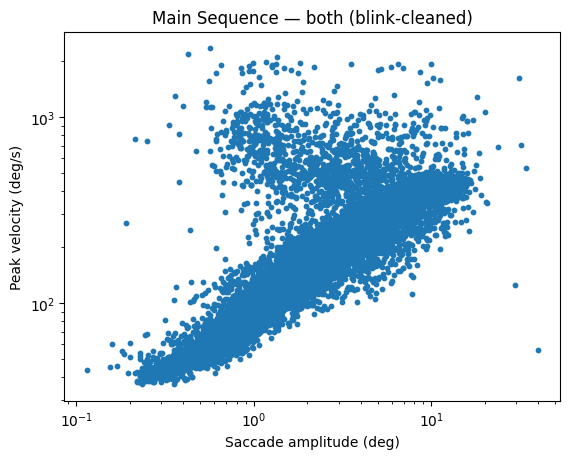

In [66]:
plot_main_sequence(saccades_df,
                   out_path = out_path,
                   out_file_format = out_file_format,
                   by_eye = by_eye,
                   title = title,
                   x_label = x_label,
                   y_label = y_label,
                   drop_near_blinks = drop_near_blinks,
                   )


Main sequence outlier summary
------------------------------
Total saccades    :  15425
Outliers          :   1460
Outlier rate      :  9.47%
Saved to          : data/out/try_out\main_sequence_+_(outlier_cleaned)-bothEyes_blinkCleaned_outliers.csv


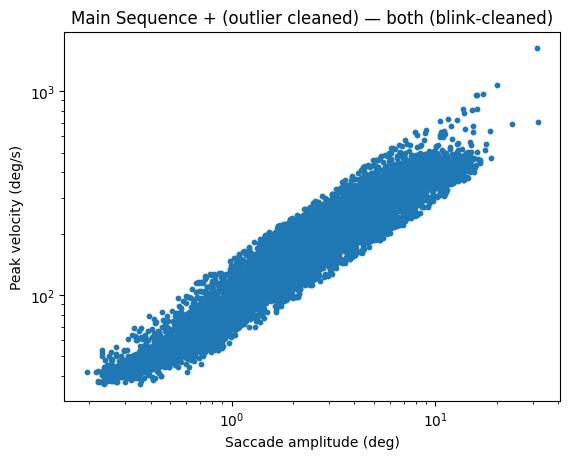

In [67]:
# drop outliers as well
plot_main_sequence(
    saccades_df,
    out_path= out_path + "/try_out",
    out_file_format = out_file_format,
    by_eye=by_eye,
    title = title + " + (outlier cleaned)",
    x_label = x_label,
    y_label = y_label,
    drop_near_blinks=drop_near_blinks,
    drop_ms_outliers=True
)

#### 2.2.1.1. Try out: Main Sequence with different window sizes to drop blinks

Saccades for near blinks annotated for window size 10


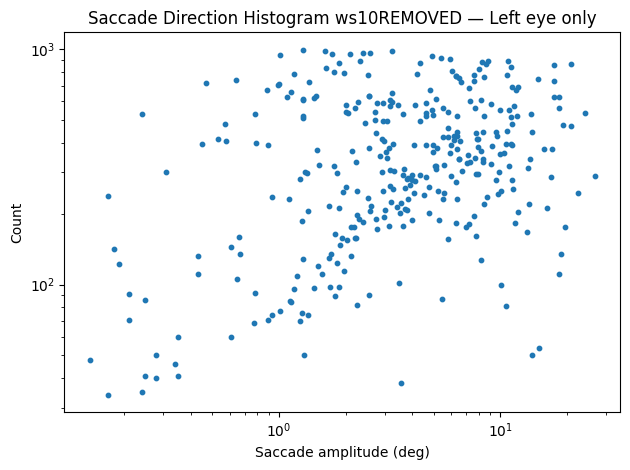

Plot saved to file 'data/out/ws10/saccade_direction_histogram_ws10removed-leftEyes.svg'


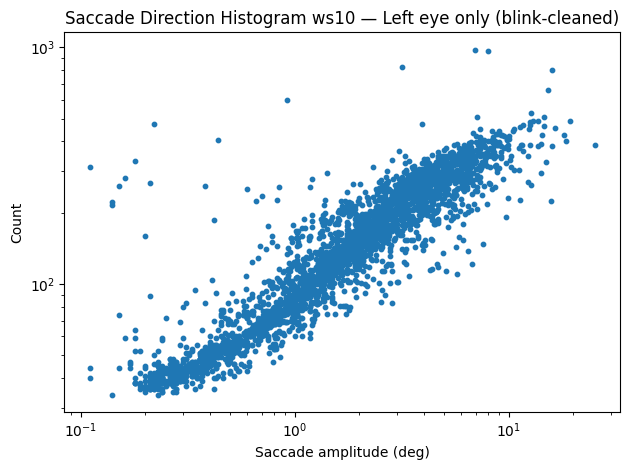

Plot saved to file 'data/out/ws10/saccade_direction_histogram_ws10-leftEyes_blinkCleaned.svg'
10 2401 delta 2401
Saccades for near blinks annotated for window size 30


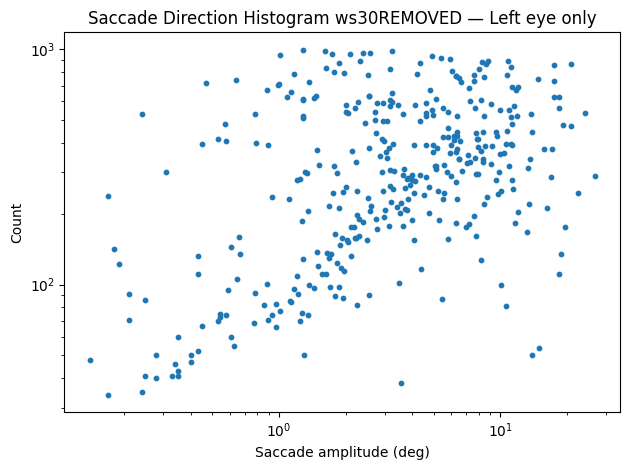

Plot saved to file 'data/out/ws30/saccade_direction_histogram_ws30removed-leftEyes.svg'


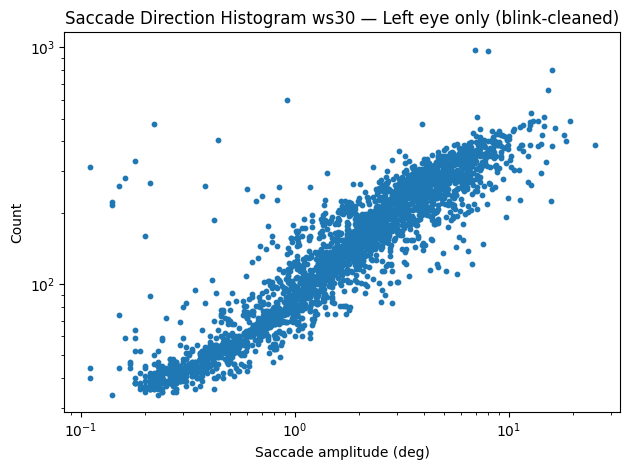

Plot saved to file 'data/out/ws30/saccade_direction_histogram_ws30-leftEyes_blinkCleaned.svg'
30 2635 delta 234
Saccades for near blinks annotated for window size 50


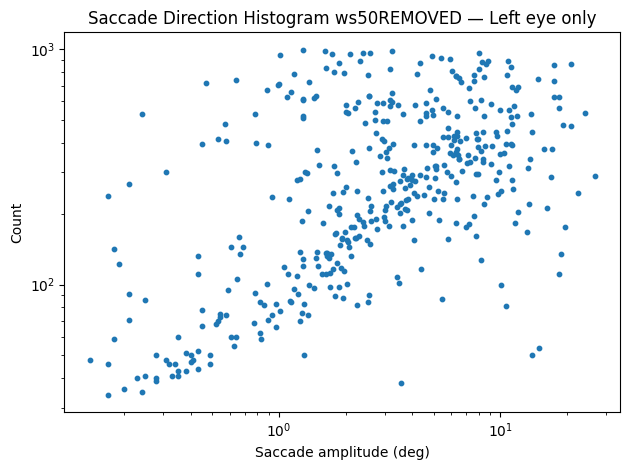

Plot saved to file 'data/out/ws50/saccade_direction_histogram_ws50removed-leftEyes.svg'


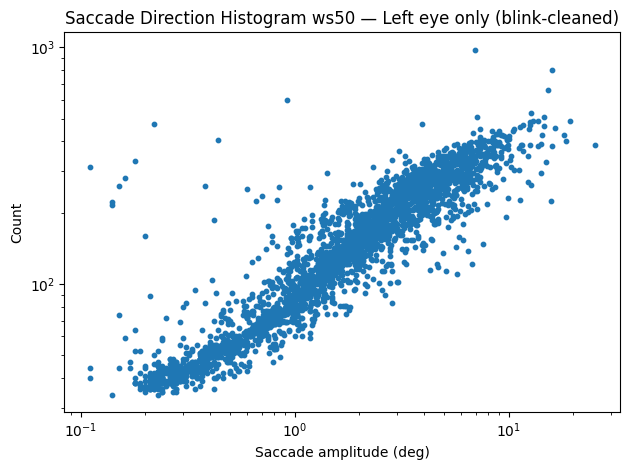

Plot saved to file 'data/out/ws50/saccade_direction_histogram_ws50-leftEyes_blinkCleaned.svg'
50 2875 delta 240
Saccades for near blinks annotated for window size 80


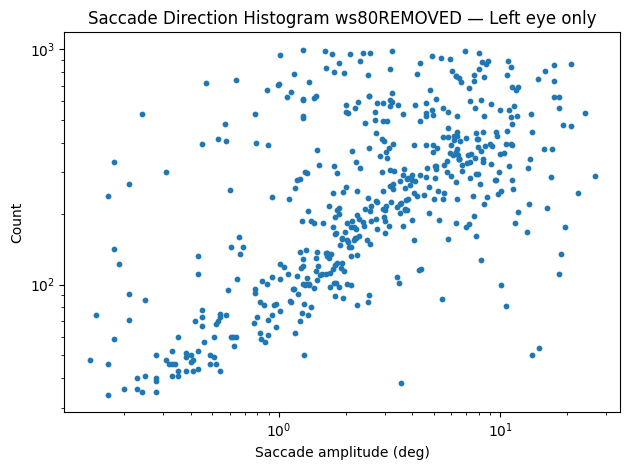

Plot saved to file 'data/out/ws80/saccade_direction_histogram_ws80removed-leftEyes.svg'


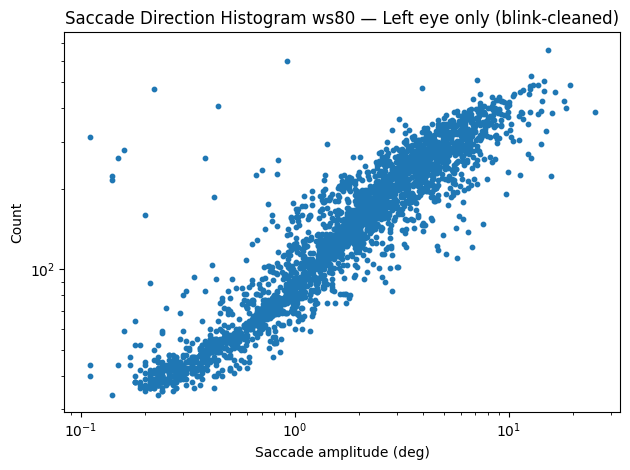

Plot saved to file 'data/out/ws80/saccade_direction_histogram_ws80-leftEyes_blinkCleaned.svg'
80 3209 delta 334
Saccades for near blinks annotated for window size 100


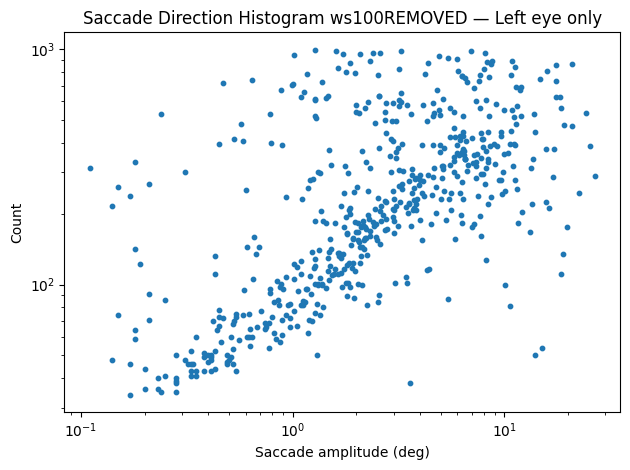

Plot saved to file 'data/out/ws100/saccade_direction_histogram_ws100removed-leftEyes.svg'


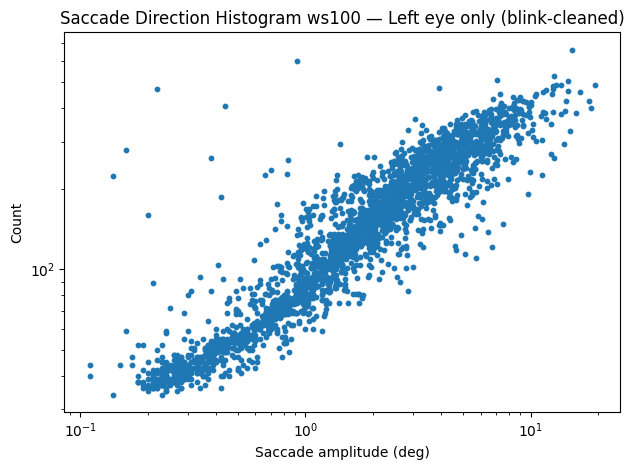

Plot saved to file 'data/out/ws100/saccade_direction_histogram_ws100-leftEyes_blinkCleaned.svg'
100 3438 delta 229
Saccades for near blinks annotated for window size 120


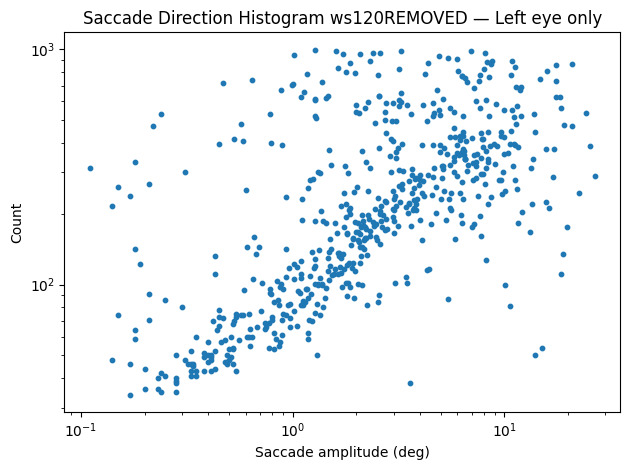

Plot saved to file 'data/out/ws120/saccade_direction_histogram_ws120removed-leftEyes.svg'


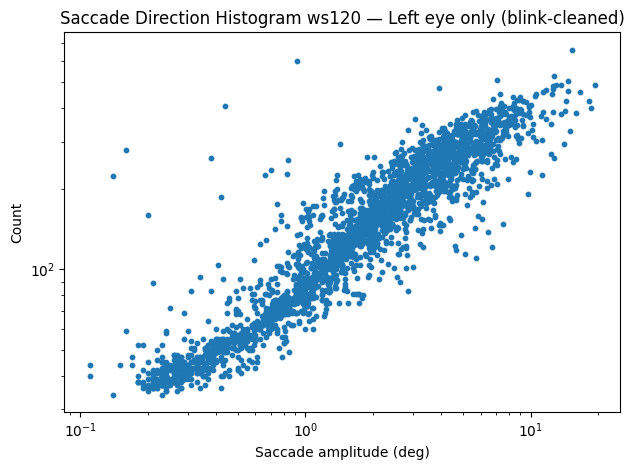

Plot saved to file 'data/out/ws120/saccade_direction_histogram_ws120-leftEyes_blinkCleaned.svg'
120 3644 delta 206
Saccades for near blinks annotated for window size 150


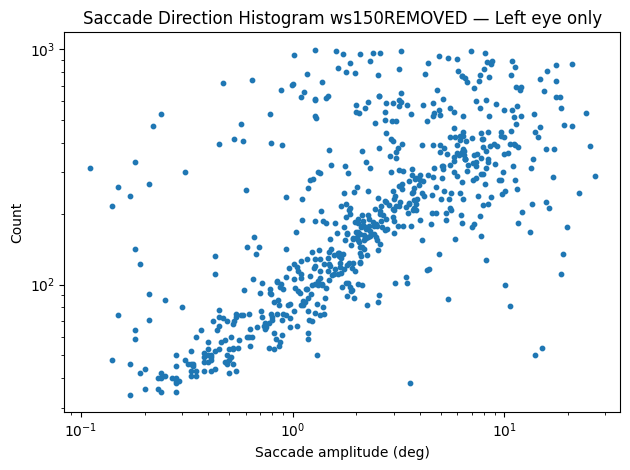

Plot saved to file 'data/out/ws150/saccade_direction_histogram_ws150removed-leftEyes.svg'


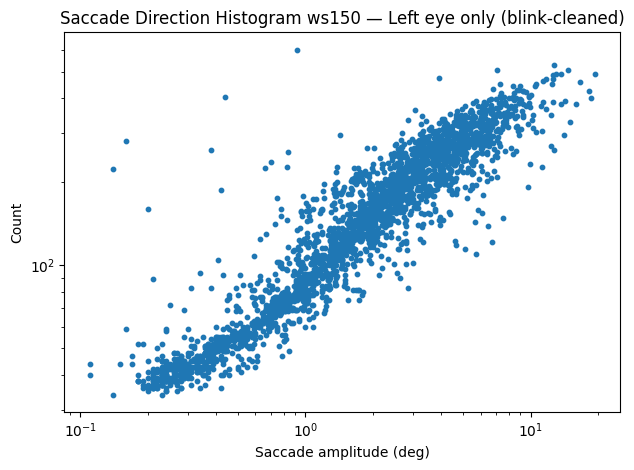

Plot saved to file 'data/out/ws150/saccade_direction_histogram_ws150-leftEyes_blinkCleaned.svg'
150 3982 delta 338
Saccades for near blinks annotated for window size 180


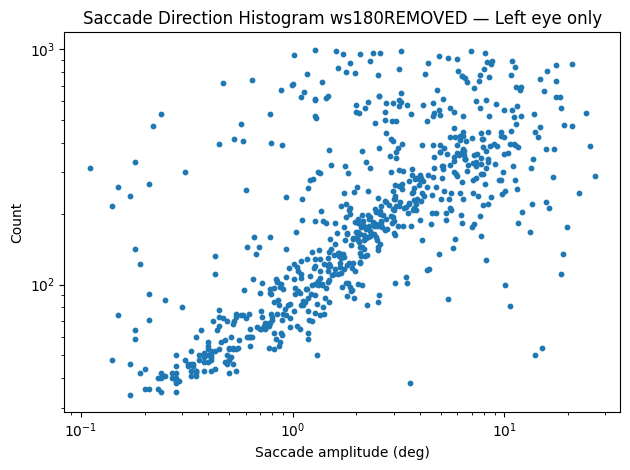

Plot saved to file 'data/out/ws180/saccade_direction_histogram_ws180removed-leftEyes.svg'


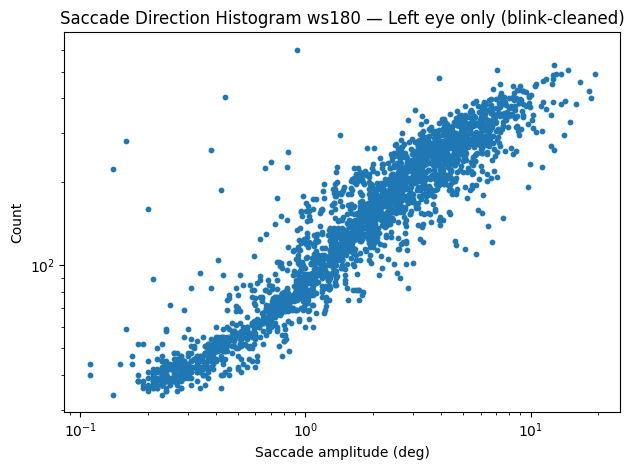

Plot saved to file 'data/out/ws180/saccade_direction_histogram_ws180-leftEyes_blinkCleaned.svg'
180 4316 delta 334


In [94]:
window_ms_list = [10, 30, 50, 80, 100, 120, 150, 180]
prev = 0
x_label = "Saccade amplitude (deg)"

for window_ms in window_ms_list:
    print(f"Saccades for near blinks annotated for window size {window_ms}")

    sc_df = annotate_saccades_near_blinks_in_df(
        saccades_df,
        blinks_df,
        window_ms=window_ms
    )

    plot_main_sequence(
        sc_df[sc_df["near_blink"]].copy(),
        out_path=out_path + f"/ws{window_ms}",
        out_file_format=out_file_format,
        by_eye=by_eye,
        title=title + f" ws{window_ms}REMOVED",
        x_label=x_label,
        y_label=y_label,
        drop_near_blinks=False,
    )

    plot_main_sequence(
        sc_df,
        out_path=out_path + f"/ws{window_ms}",
        out_file_format=out_file_format,
        by_eye=by_eye,
        title=title + f" ws{window_ms}",
        x_label=x_label,
        y_label=y_label,
        drop_near_blinks=drop_near_blinks,
    )

    # Sanity check
    cur = int(sc_df["near_blink"].sum())
    print(window_ms, cur, "delta", cur - prev)
    prev = cur


In [86]:
print("drop_near_blinks =", drop_near_blinks)

drop_near_blinks = True


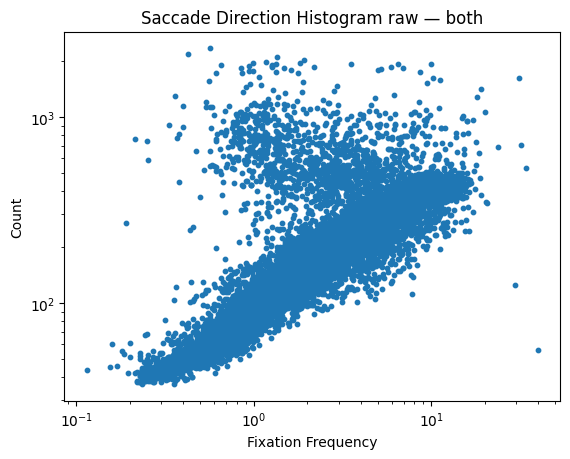

In [87]:
# Unprocessed / raw main sequence
plot_main_sequence(
    saccades_df,
    out_path=out_path + "/raw",
    out_file_format=out_file_format,
    by_eye=by_eye,
    title=title + " raw",
    x_label=x_label,
    y_label=y_label,
    drop_near_blinks=False,   # raw has no near-blink removal
)


### 2.2.2 Fixation Duration
specify the parameters for the fixation duration plot

In [70]:
min_ms = 60,           # drop ultra-short blinks/micro-fixations
max_ms = 1000,         # drop implausibly long fixations
bin_w = 20,              # bin width in ms
title = "Fixation Durations"
x_label = "Fixation duration (ms)"
y_label = "Count"

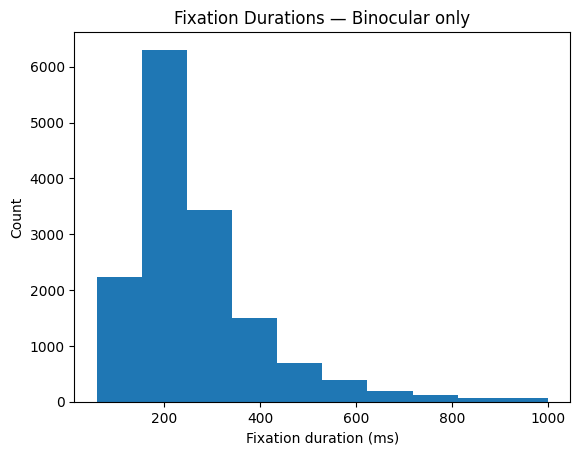

Plot saved to file 'data/out/fixation_durations-bothEyes.svg'


In [71]:
plot_fixation_duration(fixations_df,
                       by_eye = by_eye,
                       min_ms = min_ms,
                       max_ms = max_ms,
                       bin_w = bin_w,
                       title = title,
                       x_label = x_label,
                       y_label = y_label,
                       out_path = out_path,
                       out_file_format = out_file_format
                       )

### 2.2.3 Saccade Amplitude
specify the parameters for the saccade smplitude plot

In [72]:
title = "Saccade Amplitude"
x_label = "Saccade amplitude (deg)"
y_label = "Count"

Total saccades: 15566
Kept saccades (<=40°): 15566
Dropped outliers (>40°): 0, 0.00%
Plot saved to file 'data/out/saccade_amplitude-bothEyes.svg'


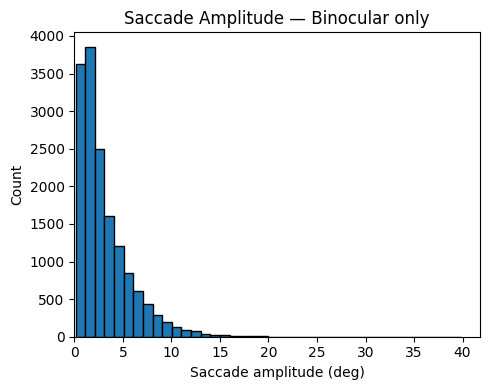

In [73]:
saccade_amplitude(saccades_df,
                  by_eye = by_eye,
                  title = title,
                  x_label = x_label,
                  y_label = y_label,
                  out_path = out_path,
                  out_file_format = out_file_format
                  )

### 2.2.4 Saccade Duration
specify the parameters for the saccade duration plot

In [74]:
title = "Saccade Duration"
x_label = "Saccade duration (ms)"
y_label = "Count"
max_saccade_duration = 120 # 100, 150, 200, 250, 300, none

Dropped 0.00% samples of duration > 120 milliseconds.
Plot saved to file 'data/out/saccade_duration-bothEyes.svg'


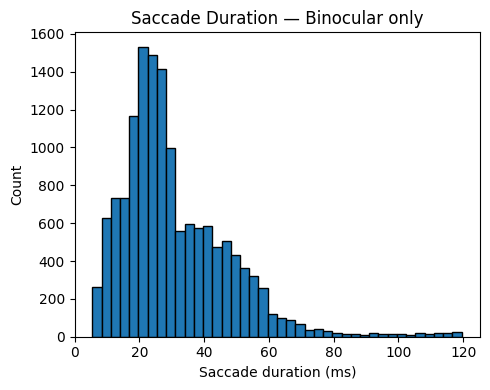

In [75]:
saccade_duration(saccades_df,
                  by_eye = by_eye,
                  title = title,
                  x_label = x_label,
                  y_label = y_label,
                  out_path = out_path,
                  out_file_format = out_file_format,
                  max_saccade_duration=max_saccade_duration
                  )

### 2.2.5 Fixation Frequency
specify the parameters for the fixation frequency plot

In [76]:
x_label = "Fixation Frequency" # Maybe 'Fixations per second' would fit better?
y_label = "Count"
title = "Fixation frequency histogram"

Plot saved to file 'data/out/fixation_frequency_histogram-bothEyes.svg'


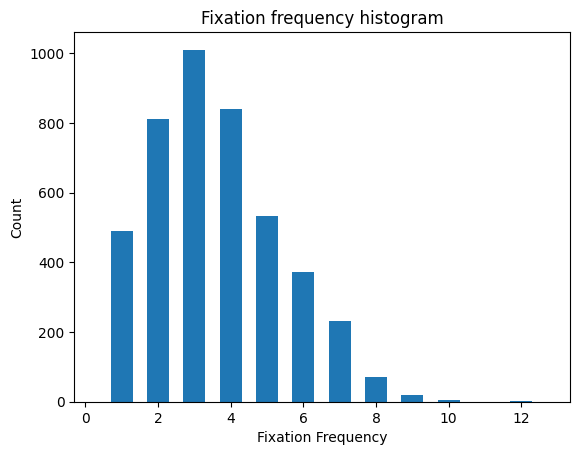

In [77]:
fixation_frequency(fixations_df,
                   by_eye = by_eye,
                   title = title,
                   x_label = x_label,
                   y_label = y_label,
                   out_path = out_path,
                   out_file_format = out_file_format
                   )

### 2.2.5 Saccade Direction Histogramm
specify the parameters for the fixation frequency plot

In [78]:
title = "Saccade Direction Histogram"
cart_title = "Cartesian Angular Histogram"
refinement = False  # refinements: weight by saccade amplitude, excluding microsaccades or artifacts

Plot saved to file 'data/out/saccade_direction_histogram-bothEyes.svg'


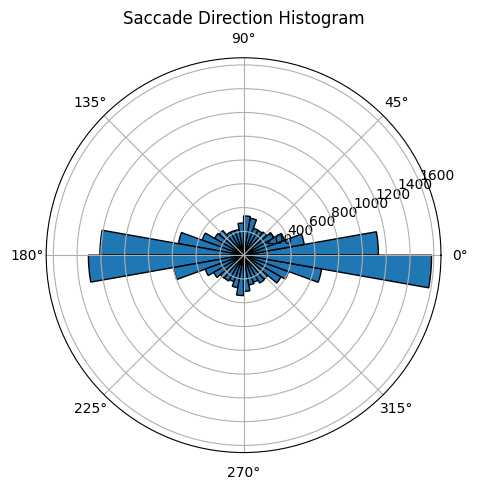

Plot saved to file 'data/out/cartesian_angular_histogram-bothEyes.svg'


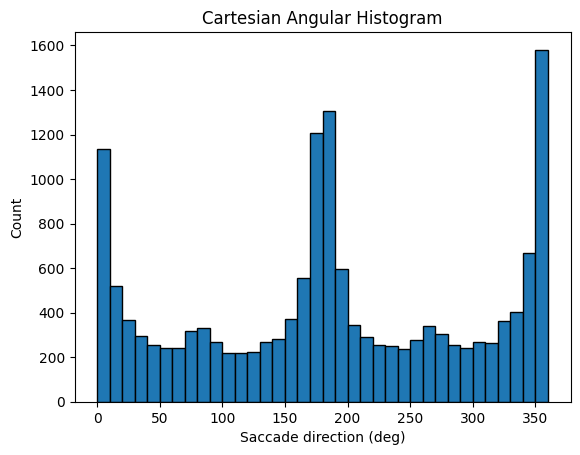

In [79]:
saccade_angular_histogram(saccades_df,
                          by_eye=by_eye,
                          title=title,
                          cart_title=cart_title,
                          out_path=out_path,
                          out_file_format=out_file_format,
                          refinement=refinement
                          )

# 3. Outlier Analysis

concat & load dfs

In [80]:
et_all = pd.concat(
    [fixations_df, saccades_df, blinks_df],
    axis=0,
    ignore_index=True,
    sort=False
)

outliers = pd.read_csv(
    r"data/out/try_out/main_sequence_+_(outlier_cleaned)-bothEyes_blinkCleaned_outliers.csv"
) # tBD: better filenaming

create 'flags' col

In [81]:
outlier_key_cols = [
    "ID",
    "eye",
    "time",
    "end_time"
]

outlier_flags = (
    outliers
    .loc[outliers["ms_is_outlier"]]
    [outlier_key_cols]
    .assign(is_outlier=True)
)

merge

In [82]:
et_all = et_all.merge(
    outlier_flags,
    on=outlier_key_cols,
    how="left"
)

et_all["is_outlier"] = et_all["is_outlier"].fillna(False)

C:\Users\chris\AppData\Local\Temp\ipykernel_21828\660600374.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  et_all["is_outlier"] = et_all["is_outlier"].fillna(False)


In [83]:
et_all

,time,end_time,duration,fix_avg_x,fix_avg_y,fix_avg_pupil_size,eye,event_type,ID,sacc_start_x,sacc_start_y,sacc_end_x,sacc_end_y,sacc_visual_angle,peak_velocity,near_blink,amplitude_deg,is_outlier
0,0.0070,0.4360,0.4300,866.05,550.05,1166.0,both,fixation,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,0.4600,0.6045,0.1455,808.10,490.50,1166.0,both,fixation,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,0.6190,0.6550,0.0370,774.80,482.95,1128.0,both,fixation,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,0.6855,0.8510,0.1665,910.95,471.70,1097.5,both,fixation,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,0.8790,1.0015,0.1235,760.80,480.05,1141.0,both,fixation,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45983,5093.5345,5093.6310,0.0975,NaN,NaN,NaN,both,blink,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
45984,5108.4970,5108.6885,0.1925,NaN,NaN,NaN,both,blink,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
45985,5112.6220,5112.7820,0.1610,NaN,NaN,NaN,both,blink,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
45986,5116.6810,5117.3400,0.6600,NaN,NaN,NaN,R,blink,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


Weird Tryout

In [84]:
raw = mne.io.read_raw_eyelink(fname="data\sub-030_ses-001_et.asc")

Loading c:\Users\chris\Documents\ArbeitUni\VIS_S-CCS\FreeViewing\Data\data\sub-030_ses-001_et.asc


<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\chris\AppData\Local\Temp\ipykernel_21828\3657746266.py:1: SyntaxWarning: invalid escape sequence '\s'
  raw = mne.io.read_raw_eyelink(fname="data\sub-030_ses-001_et.asc")


Pixel coordinate data detected.Pass `scalings=dict(eyegaze=1e3)` when using plot method to make traces more legible.
Pupil-size area detected.
No button events found in this file.


C:\Users\chris\AppData\Local\Temp\ipykernel_21828\3657746266.py:1: SyntaxWarning: invalid escape sequence '\s'
  raw = mne.io.read_raw_eyelink(fname="data\sub-030_ses-001_et.asc")


TypeError: 'NoneType' object is not subscriptable